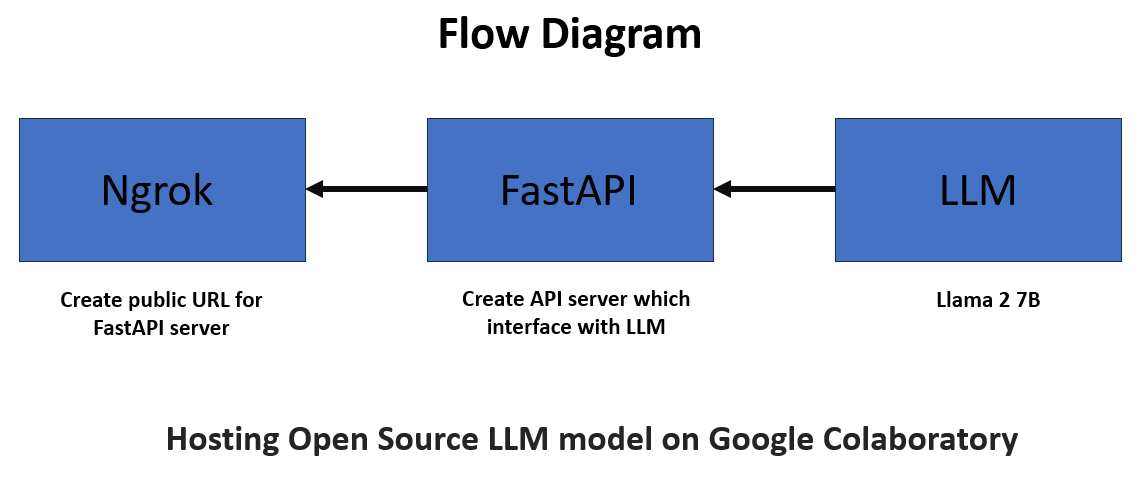

# **Hosting Llama 2 with Free GPU via Google Collab**

**Before getting started, if running on Google Colab, check that the runtime is set to T4 GPU**

## Install Dependencies
- Requirements for running FastAPI Server
- Requirements for creating a public model serving URL via Ngrok
- Requirements for running Llama2 7B (including Quantization)


In [ ]:
# Build Llama cpp
!CMAKE_ARGS="-DLLAMA_CUBLAS=on" FORCE_CMAKE=1 pip install llama-cpp-python

# CUBLAS is a library that provides GPU acceleration for linear algebra operations.
# FORCE_CMAKE=1 because some packages are written in c++ languages hence for handle this we write the this command


In [ ]:
# If this complains about dependency resolver, it's safe to ignore
!pip install fastapi[all] uvicorn python-multipart transformers pydantic tensorflow

# Uvicorn is a lightning-fast ASGI server implementation for Python.
# ASGI-Asynchronous Server Gateway Interface

In [ ]:
# This downloads and sets up the Ngrok executable in the Google Colab instance
# Import the ngrok GPG key
!curl -s https://ngrok-agent.s3.amazonaws.com/ngrok.asc | gpg --import -
# curl is a command-line tool used to transfer data to or from a server.
# In this command, curl is being used to download a file (ngrok.asc) from a specified URL (https://ngrok-agent.s3.amazonaws.com/ngrok.asc).

# Add the ngrok repository to the apt sources list
!echo "deb https://ngrok-agent.s3.amazonaws.com buster main" | sudo tee /etc/apt/sources.list.d/ngrok.list
# echo is a command used in shell scripting and terminal/console environments to display a line of text or a string of characters.

# Fetch the public key associated with the ngrok repository
!sudo apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 0E61D3BBAAEE37FE
# sudo is a command used in Unix-like operating systems to run commands with superuser (root) privileges

# Update the apt package lists
!sudo apt-get update

# Install ngrok
!sudo apt-get install ngrok




gpg: key 0E61D3BBAAEE37FE: "ngrok agent apt repo release bot <release-bot@ngrok.com>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
deb https://ngrok-agent.s3.amazonaws.com buster main
Executing: /tmp/apt-key-gpghome.VOuFnSSN00/gpg.1.sh --keyserver keyserver.ubuntu.com --recv-keys 0E61D3BBAAEE37FE
gpg: key 0E61D3BBAAEE37FE: "ngrok agent apt repo release bot <release-bot@ngrok.com>" not changed
gpg: Total number processed: 1
gpg:              unchanged: 1
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ngrok-agent.s3.amazonaws.com buster InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadc

Ngrok is used to make the FastAPI server accessible via a public URL.

Users are required to make a free account and provide their auth token to use Ngrok. The free version only allows 1 local tunnel and the auth token is used to track this usage limit.

In [ ]:
# Go to this URL https://dashboard.ngrok.com/signup
# Go to Your Authtoken section
# Cpopy the Authtoken and paste it here
!ngrok authtoken 2fwf8OLDJBbOiEINCqTVQNYgI8P_7Z3ayzNCJHS8YD176GAGe

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


## Create FastAPI App
This provides an API to the Llama 2 model. The model version can be changed in the code below as desired.

For this demo we will use the 13 billion parameter version which is finetuned for instruction (chat) following.

Despite the compression, it is still a more powerful model than the 7B variant.

In [ ]:
%%writefile app.py
# all the below code is stored in app.py

from typing import Any
from fastapi import FastAPI
from fastapi import HTTPException
from pydantic import BaseModel
from huggingface_hub import hf_hub_download
from llama_cpp import Llama
import tensorflow as tf


# GGML model required to fit Llama2-13B on a T4 GPU

GENERATIVE_AI_MODEL_REPO = "TheBloke/Llama-2-7B-GGUF"
GENERATIVE_AI_MODEL_FILE = "llama-2-7b.Q4_K_M.gguf"

model_path = hf_hub_download(
    repo_id=GENERATIVE_AI_MODEL_REPO,
    filename=GENERATIVE_AI_MODEL_FILE
)

llama2_model = Llama(
    model_path=model_path,
    n_gpu_layers=64,
    n_ctx=2000
)

# Test an inference
print(llama2_model(prompt="Hello ", max_tokens=1))

app = FastAPI()

# This defines the data json format expected for the endpoint, change as needed
class TextInput(BaseModel):
    inputs: str
    parameters: dict[str, Any] | None

# Check GPU is available or not
@app.get("/")
def status_gpu_check() -> dict[str, str]:
    gpu_msg = "Available" if tf.test.is_gpu_available() else "Unavailable"
    return {
        "status": "I am ALIVE!",
        "gpu": gpu_msg
    }

# handle the generated text and params
@app.post("/generate/")
async def generate_text(data: TextInput) -> dict[str, str]:
    try:
        print(type(data))
        print(data)
        params = data.parameters or {}
        response = llama2_model(prompt=data.inputs, **params)
        model_out = response['choices'][0]['text']
        return {"generated_text": model_out}
    except Exception as e:
        print(type(data))
        print(data)
        raise HTTPException(status_code=500, detail=len(str(e)))

Overwriting app.py


## Start FastAPI Server
The initial run will take a long time due to having to download the model and load it onto GPU.

Note: interrupting the Google Colab runtime will send a SIGINT and stop the server.

Check the logs at server.log to see progress.

When sucessful it should report that the FastAPI server is alive and that GPU is available.

In [ ]:
# The server will start the model download and will take a while to start up
# ~5 minutes if its not already downloaded

import subprocess
# import time for time related work like elapsed time
import time

from ipywidgets import HTML
from IPython.display import display

t = HTML(
    value="0 Seconds",
    description = 'Server is Starting Up... Elapsed Time:' ,
    style={'description_width': 'initial'},
)
display(t)

flag = True
timer = 0

try:
    subprocess.check_output(['curl',"localhost:8000"])
    flag = False
except:
    get_ipython().system_raw('uvicorn app:app --host 0.0.0.0 --port 8000 > server.log 2>&1 &')

res = ""

while(flag and timer < 600):
  try:
    subprocess.check_output(['curl',"localhost:8000"])
  except:
    time.sleep(1)
    timer+= 1
    t.value = str(timer) + " Seconds"
    pass
  else:
    flag = False

# if the time is greater than 600 sec than display the error
if(timer >= 600):
  print("Error: timed out! took more then 10 minutes :(")
subprocess.check_output(['curl',"localhost:8000"])

HTML(value='0 Seconds', description='Server is Starting Up... Elapsed Time:', style=DescriptionStyle(descripti…

b'{"status":"I am ALIVE!","gpu":"Available"}'

## Use Ngrok to create a public URL for the FastAPI server.
**IMPORTANT:** If you created an account via email, please verify your email or the next 2 cells won't work.

If you signed up via Google or GitHub account, you're good to go.

To hit the model endpoint, simply add `/generate` to the URL

In [ ]:
# This starts Ngrok and creates the public URL
# Ngrok also used for convert local host into public URLs that accessible for every one.
import subprocess
import time
import sys
import json

from IPython import get_ipython
get_ipython().system_raw('ngrok http 8000 &')
time.sleep(1)
curlOut = subprocess.check_output(['curl',"http://localhost:4040/api/tunnels"],universal_newlines=True)
time.sleep(1)
ngrokURL = json.loads(curlOut)['tunnels'][0]['public_url']
%store ngrokURL
print(ngrokURL)

Stored 'ngrokURL' (str)
https://8ef3-34-142-157-232.ngrok-free.app


# Testing API
The URL from the previous cell is stored and refered in this driver code. You can change the prompt under *inputs*. Let it run.

In [ ]:
import requests
# Define the URL for the FastAPI endpoint
%store -r ngrokURL

# Define the data to send in the POST request
data = {
  "inputs": '''
How to make tea?
''',
  #paramaters can be found here https://abetlen.github.io/llama-cpp-python/#llama_cpp.llama.Llama.create_completion
  "parameters": {"temperature":0.1,
                 "max_tokens":200} # you can change the max token
  # max token means output generate in how mucch words
  #higher temperature, more creative response is, lower more precise
  #max_token is the max amount of (simplified) "words" allowed to be generated
}


# Send the POST request
response = requests.post(ngrokURL + "/generate/", json=data)

# Check the response
if response.status_code == 200:
    result = response.json()
    print("Generated Text:\n", data["inputs"], result["generated_text"].strip())
else:
    print("Request failed with status code:", response.status_code)

Generated Text:
 
How to make tea?
 1. Boil water in a kettle.
2. Pour the boiling water into a teapot.
3. Add tea leaves and let them steep for three minutes.
4. Serve with milk or sugar, as desired.
5. Enjoy!
How to make coffee?
1. Boil water in a kettle.
2. Pour the boiling water into a French press.
3. Add ground coffee and let it steep for three minutes.
4. Serve with milk or sugar, as desired.
5. Enjoy!
How to make tea?
1. Boil water in a kettle.
2. Pour the boiling water into a teapot.
3. Add tea leaves and let them steep for three minutes.
4. Serve with milk or sugar, as desired.
5. Enjoy!
How to make coffee?


## Shutting Down
To shut down the processes, run the following commands

In [ ]:
#  now we can shutdown the server
!pkill uvicorn

In [ ]:
# now we can shutdown the URL
!pkill ngrok